### Assignment 1. Download "Citeseer" graph in Pytorch Geometric and then: 

Questions:

1) Show some graph statistics of the graph, i.e., Number of nodes and Number of edges.
2) Training GIN model for node classification

In [1]:
import torch
# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="citeseer")

data = dataset[0]

Processing...
Done!


In [3]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


data

Dataset: citeseer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [4]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


<BarContainer object of 32 artists>

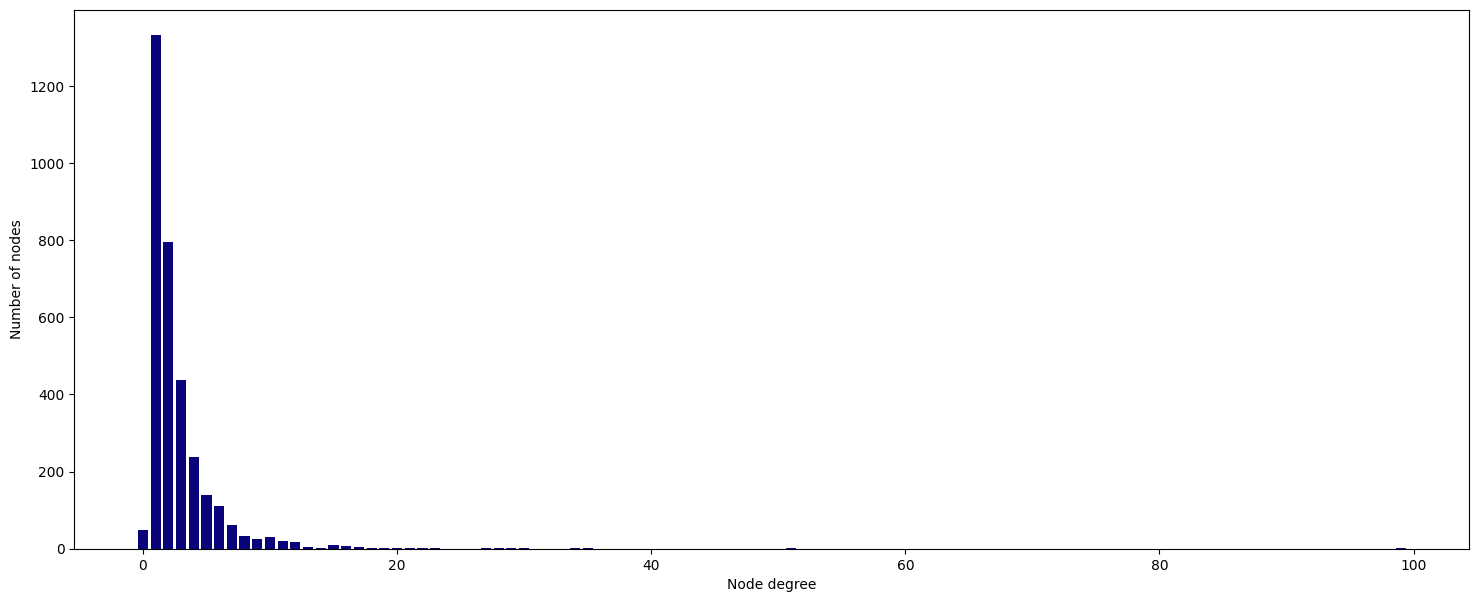

In [5]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [6]:
import torch
from torch import Tensor
from torch_geometric.nn.conv import MessagePassing
from typing import Callable

class GINConv(MessagePassing):
    def __init__(self, nn: Callable, eps: float = 0., train_eps: bool = False):
        # Initialize the MessagePassing base class with 'add' aggregation
        super().__init__(aggr='add')
        
        # Neural network for updating node features
        self.nn = nn
        
        # Epsilon value to adjust how much of the current node's feature is kept
        self.eps = torch.nn.Parameter(torch.tensor([eps])) if train_eps else torch.tensor([eps])
    
    def reset_parameters(self):
        # Reset neural network parameters
        self.nn.reset_parameters()
        # Reset epsilon to the initial value
        self.eps.data.fill_(self.eps.item())
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:  
        # Propagate messages between nodes based on edge connections
        out = self.propagate(edge_index, x=x)
        
        # Update the node features by combining the propagated messages and self-loops
        out = out + (1 + self.eps) * x
        
        # Pass the updated features through the neural network
        return self.nn(out)
    
    def message(self, x_j: Tensor) -> Tensor:
        # Message function: simply pass the features from neighbors
        return x_j

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'

In [7]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_features, num_classes, dim=16, drop=0.5):
        super(GIN, self).__init__()
        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, num_classes))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_classes)
        self.drop = torch.nn.Dropout(p=0.5)
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.selu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.drop(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.bn2(x)
        return x, F.softmax(x, dim=1)

In [8]:
%%time

# Create GIN model
gin = GIN(dataset.num_features, dataset.num_classes, 8)
print(gin)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3703, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
  ))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=6, bias=True)
  ))
  (bn2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
CPU times: user 3.63 ms, sys: 137 µs, total: 3.77 ms
Wall time: 3.35 ms


In [9]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [10]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [11]:
# Train
train(gin, data)

# Test
acc = test(gin, data)
print(f'\nGIN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.792 | Train Acc:  22.50% | Val Loss: 1.81 | Val Acc: 14.40%
Epoch   1 | Train Loss: 1.753 | Train Acc:  26.67% | Val Loss: 1.78 | Val Acc: 19.00%
Epoch   2 | Train Loss: 1.723 | Train Acc:  33.33% | Val Loss: 1.76 | Val Acc: 22.80%
Epoch   3 | Train Loss: 1.672 | Train Acc:  45.00% | Val Loss: 1.75 | Val Acc: 26.80%
Epoch   4 | Train Loss: 1.665 | Train Acc:  45.00% | Val Loss: 1.75 | Val Acc: 25.20%
Epoch   5 | Train Loss: 1.598 | Train Acc:  55.83% | Val Loss: 1.72 | Val Acc: 32.20%
Epoch   6 | Train Loss: 1.621 | Train Acc:  49.17% | Val Loss: 1.74 | Val Acc: 30.00%
Epoch   7 | Train Loss: 1.592 | Train Acc:  53.33% | Val Loss: 1.73 | Val Acc: 29.60%
Epoch   8 | Train Loss: 1.538 | Train Acc:  63.33% | Val Loss: 1.71 | Val Acc: 31.80%
Epoch   9 | Train Loss: 1.538 | Train Acc:  51.67% | Val Loss: 1.72 | Val Acc: 30.80%
Epoch  10 | Train Loss: 1.507 | Train Acc:  63.33% | Val Loss: 1.71 | Val Acc: 32.40%
Epoch  11 | Train Loss: 1.478 | Train Acc:  62.50% | V

### Assignment 2. Load the  IMDB-BINARY dataset from Torch Geometric.

Questions: Train the GIN model on graph-level classification


In [25]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY').shuffle()

Processing...
Done!


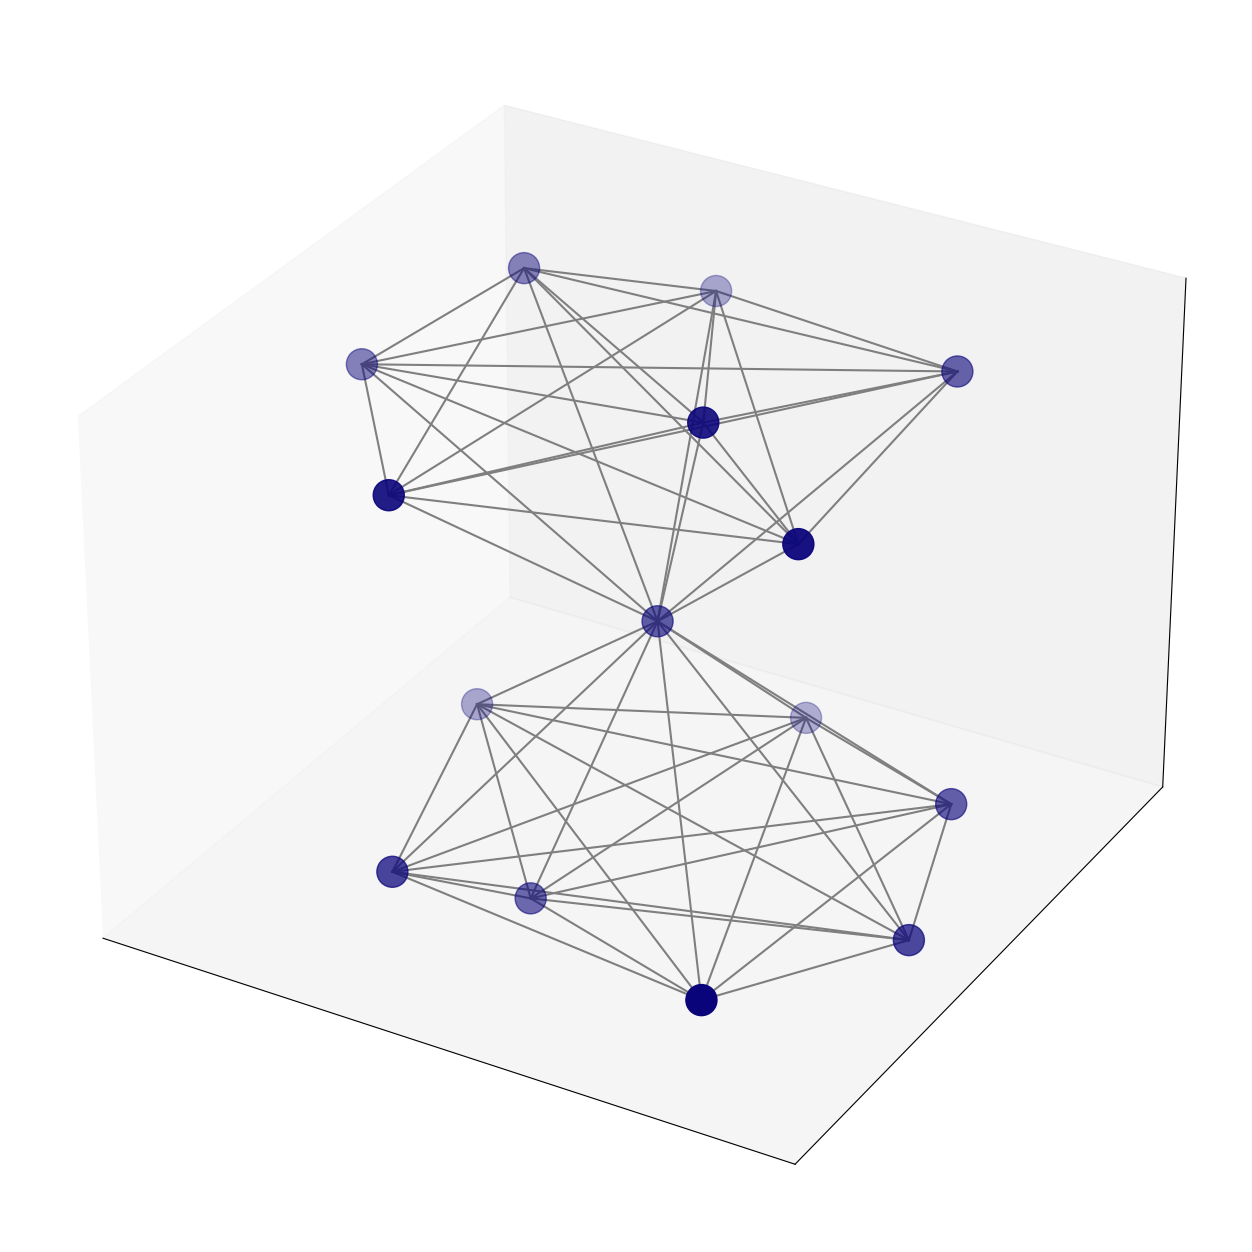

In [26]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

pos = nx.spring_layout(G, dim=3, seed=0)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

ax.scatter(*node_xyz.T, s=500, c="#0A047A")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

plt.show()

In [27]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 800 graphs
Validation set = 100 graphs
Test set       = 100 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 10314], y=[64], num_nodes=1144, batch=[1144], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 10302], y=[64], num_nodes=1125, batch=[1125], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 12288], y=[64], num_nodes=1247, batch=[1247], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 16498], y=[64], num_nodes=1439, batch=[1439], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 12422], y=[64], num_nodes=1277, batch=[1277], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 10946], y=[64], num_nodes=1280, batch=[1280], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 13402], y=[64], num_nodes=1273, batch=[1273], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 11272], y=[64], num_nodes=1238, batch=[1238], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 10368], y=[64], num_nodes=1173, batch=[1173], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 11476], y=[64], num_nodes=1

In [28]:
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch

class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        if x is None:
            x = torch.zeros((batch.size(0), dataset.num_node_features), device=edge_index.device)
        elif x.dim() == 1:
            x = x.unsqueeze(-1)

        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

In [29]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 30

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            val_loss, val_acc = test(model, val_loader)

        if(epoch % 5 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.91 | Train Acc: 50.00% | Val Loss: 0.70 | Val Acc: 61.81%
Epoch   5 | Train Loss: 0.66 | Train Acc: 63.10% | Val Loss: 0.66 | Val Acc: 60.68%
Epoch  10 | Train Loss: 0.60 | Train Acc: 68.27% | Val Loss: 0.57 | Val Acc: 70.40%
Epoch  15 | Train Loss: 0.58 | Train Acc: 68.15% | Val Loss: 0.58 | Val Acc: 71.09%
Epoch  20 | Train Loss: 0.61 | Train Acc: 64.90% | Val Loss: 0.56 | Val Acc: 69.27%
Epoch  25 | Train Loss: 0.61 | Train Acc: 68.15% | Val Loss: 0.53 | Val Acc: 74.83%
Epoch  30 | Train Loss: 0.56 | Train Acc: 70.19% | Val Loss: 0.55 | Val Acc: 74.48%
Test Loss: 0.55 | Test Acc: 71.09%


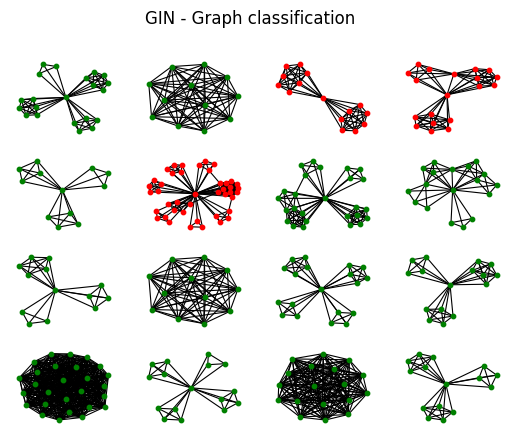

In [30]:
from torch_geometric.data import Batch

fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    data = Batch.from_data_list([data])
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )